# Degree Distribution

In [1]:
import build_influence_network as bn
import csv
import math
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
import seaborn as sns
import scipy.stats as st


In [2]:
# As a csv.reader is usuable once and only once we write the lines of our csv file to a list 
with open("influence_data.csv", "rt") as infile:
    reader = csv.reader(infile)
    next(reader)
    influence_data = list(reader)
    
# As a csv.reader is usuable once and only once we write the lines of our csv file to a list 
with open("data_by_artist.csv", "rt") as infile:
    reader = csv.reader(infile)
    next(reader)
    artist_data = list(reader)

In [3]:
graph = bn.build_graph(influence_data, artist_data)

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Name: 
Type: DiGraph
Number of nodes: 5603
Number of edges: 42770
Average in degree:   7.6334
Average out degree:   7.6334
Our artistic influence network has 5603 artists.
Our artistic influence network has 42770 edges out of a possible 31388006 possible edges.
Our graph is an acyclic directed graph: False
Our network density is: 0.0013626223978675167
Our graph is strongly connectayed: False
The number of strongly connected components is: 4747
Our graph is weakly connected: False
The number of weakly connected components is: 3
The average clustering coefficient is: 0.09128001728442253
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


Let's use seaborn's  <a href="https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn.displot" title=”Distplot”>distplot</a> function to plot both the histogram of the degree distribution of our graph, which is represented as light blue bars, and the the kernal dentisty estimate (KDE) which is represented by a solid blue line. 

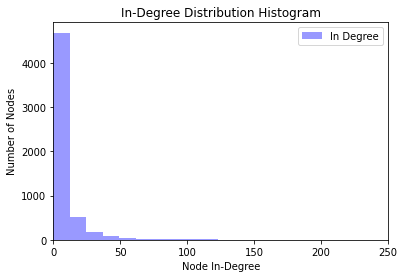

In [30]:
def plot_degree_dist(graph):
    """
    Plots a histograph of the in degree distribution of the nodes of a directed graph.
    Parameters
    ----------
    graph : a NetworkX directed graph 

    Notes
    -----
    """
    in_degrees = [graph.in_degree(n) for n in graph.nodes()]
    out_degrees = [graph.out_degree(n) for n in graph.nodes()]
    #in_bin_num = math.sqrt(len(in_degrees))
    #out_bin_num = math.sqrt(len(out_degrees))
    sns.distplot(in_degrees, label = "In Degree", color = "b", kde= False)
    #sns.distplot(out_degrees, label = "Out Degree", color = "r", kde= True)
    plt.xlim([0,250])
    plt.title("In-Degree Distribution Histogram")
    plt.ylabel("Number of Nodes")
    plt.xlabel("Node In-Degree")
    plt.legend(loc='upper right')
    plt.show()

plot_degree_dist(graph)

A function p(x) obeys a power law if \begin{equation} p(x) \propto Cx^{-\alpha} \end{equation}

We care an awful lot about power laws because they are scale invariant. What does this mean?
Given some $p(x) = Cx^{\alpha}$ scaling the argument x by some constant factor S causes a proportionate scaling of the function istelf. \begin{equation} p(Sx) = C(Sx)^{\alpha} = SC^{\alpha}p(x) \propto p(x) \end{equation}
That is, scaling by a constant S simply multiplies the original function by the constant $C^{\alpha}$

Power laws are often associated with heavy-tailed distributions, which we have. Unfortunately, power laws are also quite difficult to fit.

To assist in our analysis we will consult <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0085777" title=”powerlaw_paper”>Alstott et. al. powerlaw: A Python Package for Analysis of Heavy-Tailed Distributions</a> and the associated python package <a href="https://github.com/jeffalstott/powerlaw" title=”powerlaw_github”>powerlaw</a> based on <a href="https://epubs.siam.org/doi/abs/10.1137/070710111?journalCode=siread" title=”clauset”>Clauset et. al. Power-law distributions in empirical data</a>



In [4]:
def compare_power_law(graph):
    """ 
    Compare a power law distribution of node in-degrees to lognormal, exponential, lognormal positive, stretched exponential, and truncated power law       

    Parameters
    ----------
    graph : a NetworkX directed graph
        
    Notes
    -----
    See comment by Aaron Clauset in the thread:
    https://stackoverflow.com/questions/49266070/comparing-power-law-with-other-distributions

    """
    data = [graph.in_degree(n) for n in graph.nodes()]
    fit = powerlaw.Fit(data, xmin = 1, discrete = True)
    print("Our alpha is: " + str(fit.power_law.alpha))
    print("Our standard error, sigma, is: " + str(fit.power_law.sigma))
    print("----------------------------------------------------------------------------------------------")
    print("Power law compared with lognormal: " + str(fit.distribution_compare('power_law', 'lognormal')))
    print("Power law compared with exponential: " + str(fit.distribution_compare('power_law', 'exponential')))
    print("Power law compared with lognormal positive: " + str(fit.distribution_compare('power_law', 'lognormal_positive')))
    print("Power law compared with stretched exponential: " + str(fit.distribution_compare('power_law', 'stretched_exponential')))
    print("Power law compard with truncated power law: " + str(fit.distribution_compare('power_law', 'truncated_power_law')))
    print("----------------------------------------------------------------------------------------------")

    """
    figPDF = powerlaw.plot_pdf(np.array(data), color='b')
    powerlaw.plot_pdf(np.array(data), linear_bins=True, color='r', ax=figPDF)
    np.seterr(divide='ignore', invalid='ignore')
    fit=powerlaw.Fit(np.array(data), discrete=True)
    #print(fit.power_law.alpha)
    print(fit.distribution_compare('power_law', 'truncated_power_law'))
    fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
    # Linear bins?
    #fit.plot_pdf(color= 'r', linear_bins=True)
    # Logarithmic bins?
    fit.plot_pdf(color = 'g')
    plt.show()
    """
compare_power_law(graph)

Values less than or equal to 0 in data. Throwing out 0 or negative values
/opt/miniconda3/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/opt/miniconda3/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /
Assuming nested distributions


Our alpha is: 1.4325712289424275
Our standard error, sigma, is: 0.007041362166718456
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-707.0064366764268, 7.809735700701705e-123)
Power law compared with exponential: (-30.108981375952013, 0.7622725014257433)
Power law compared with lognormal positive: (-707.0064366764268, 7.809735700701705e-123)
Power law compared with stretched exponential: (-735.0094938775318, 6.978599746088565e-124)
Power law compard with truncated power law: (821.366259069607, 0.0)
----------------------------------------------------------------------------------------------


What is this telling us?

The Powerlaw package will fit a powerlaw to our emperical data and then compare it to other distributions to see which is, to be crude, the least bad fit. 

What were seeing is:

(1) an R value, which is: "The loglikelihood ratio of the two sets of likelihoods. If positive, the first set of likelihoods is more likely (and so the probability distribution that produced them is a better fit to the data). If negative, the reverse is true."

(2) a p-value, which is: The significance of the sign of R. The p-values referred to here come from section 4.1 of arxiv.org/abs/0706.1062, where large values represent good fits and small values represent bad fits. See in particular footnote 8 on the bottom of page 17. To quote Aaron Clauset's comment (which is linked in plot_power_law's comments) regarding the output:
"The thing that is being tested for the p-value here is whether the sign of R is meaningful. If p < 0.05 for a LRT, then a positive sign indicated the power-law model is favored."

What we see here is that both the lognormal and the stretched exponential (also known as the Weibull distribution) both provide a better fit for our emperical data than a powerlaw. Again, this is not too terrribly surprising as scale-free networks have proven to be rare in <a href= https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6399239/ title="clauset">Broido et. al.</a>

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/opt/miniconda3/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/opt/miniconda3/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


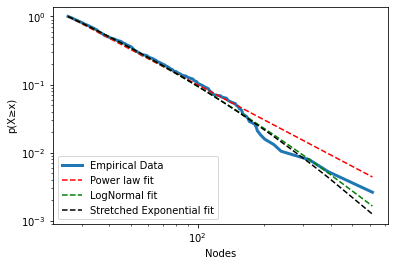

In [6]:
def plot_power_law(graph):
    in_degrees = [val for (node, val) in graph.in_degree()]
    fit1 = powerlaw.Fit(in_degrees, discrete=False)
    fit2 = powerlaw.Fit(in_degrees, discrete=False)
    ####
    fit1.distribution_compare('power_law', "lognormal")
    fit1.distribution_compare('power_law', "stretched_exponential")
    fig = fit1.plot_ccdf(linewidth=3, label='Empirical Data')
    fit1.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label="Power law fit")
    fit1.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label= "LogNormal fit")
    fit2.stretched_exponential.plot_ccdf(ax=fig, color='k', linestyle='--', label="Stretched Exponential fit")


    ####
    fig.set_ylabel(u"p(X≥x)")
    fig.set_xlabel("Nodes")
    handles, labels = fig.get_legend_handles_labels()
    fig.legend(handles, labels, loc=3)

    figname = "PowerLaw Compare"
    plt.savefig("PowerLaw_Compare.png")
    #savefig(figname+'.eps', bbox_inches='tight')
    #savefig(figname+'.tiff', bbox_inches='tight', dpi=300)
plot_power_law(graph)

What is the above graph telling us. It's a fit of the Power law, LogNormal, and Stretched Exponentials to our emperical data but it doesn't quite look like the degree distribution histogram above. 

To quote Coscia's The Atlas for the Aspiring Network Scientist Section 6.2 p.100
The most common way to visualize degrees is by drawing cumula- tive distributions (CDF), or – to be more aligned with the convention you’ll see everywhere – the complement of a cumulative distribution (CCDF). We can transform a degree histogram into a CCDF by chang- ing the meaning of the y-axis. Rather than being the probability of finding a node of degree equal to k, in a CCDF this is the probability of finding a node of degree k or higher. This is not a scattergram any more, but a function, which helps us when we need to fit it. 

In [51]:
graph_1930 = bn.build_decade_graph(graph, 1930)
print(print(nx.info(graph_1930)))

The decade that we have selected is: 1930
Our graph is an acyclic directed graph: False
Our artistic influence network has 155 artists.
Our artistic influence network has 129 edges out of a possible 23870 possible edges.
Our network density is: 0.0054042731462086305
Name: 
Type: DiGraph
Number of nodes: 155
Number of edges: 129
Average in degree:   0.8323
Average out degree:   0.8323
None


In [78]:
plot_power_law(graph_1930)

Our alpha is: 7.180603939735204
Our standard error, sigma, is: 2.523220992431114
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-0.17681722737596195, 0.33687280889629456)
Power law compared with exponential: (1.2259936396366784, 0.02931374063552603)
Power law compared with lognormal positive: (0.5373468828548369, 0.07024334608967621)
Power law compared with stretched exponential: (0.20307953653615796, 0.012345905629201058)
Power law compard with truncated power law: (7.026217385686095e-10, 0.9999700900387477)
----------------------------------------------------------------------------------------------


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions


In [60]:
graph_1940 = bn.build_decade_graph(graph, 1940)
print(print(nx.info(graph_1940)))

The decade that we have selected is: 1940
Our graph is an acyclic directed graph: False
Our artistic influence network has 400 artists.
Our artistic influence network has 826 edges out of a possible 159600 possible edges.
Our network density is: 0.005175438596491228
Name: 
Type: DiGraph
Number of nodes: 400
Number of edges: 826
Average in degree:   2.0650
Average out degree:   2.0650
None


In [79]:
plot_power_law(graph_1940)

Our alpha is: 2.7792885123718785
Our standard error, sigma, is: 0.20969116213091327
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-0.08362020891021693, 0.7905915145412576)
Power law compared with exponential: (5.855794286903986, 0.13368674854597842)
Power law compared with lognormal positive: (0.4982692992056723, 0.6885320751011426)
Power law compared with stretched exponential: (-0.10244471432654789, 0.8648012787191872)
Power law compard with truncated power law: (-0.4743129833853206, 0.3300692924021311)
----------------------------------------------------------------------------------------------


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


In [96]:
graph_1950 = bn.build_decade_graph(graph, 1950)
print(print(nx.info(graph_1950)))

The decade that we have selected is: 1950
Our graph is an acyclic directed graph: False
Our artistic influence network has 940 artists.
Our artistic influence network has 3506 edges out of a possible 882660 possible edges.
Our network density is: 0.003972084381301973
Name: 
Type: DiGraph
Number of nodes: 940
Number of edges: 3506
Average in degree:   3.7298
Average out degree:   3.7298
None


In [80]:
plot_power_law(graph_1950)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


Our alpha is: 2.526183394781592
Our standard error, sigma, is: 0.1010739644601796
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-0.3594296561205903, 0.5785805523857904)
Power law compared with exponential: (27.118035079642283, 0.0012382955121685612)
Power law compared with lognormal positive: (1.2289714123779918, 0.571334072367099)
Power law compared with stretched exponential: (-0.43778868741344157, 0.7045432580159642)
Power law compard with truncated power law: (-1.7111798850989928, 0.06431901234845305)
----------------------------------------------------------------------------------------------


In [58]:
graph_1960 = bn.build_decade_graph(graph, 1960)
print(print(nx.info(graph_1960)))

The decade that we have selected is: 1960
Our graph is an acyclic directed graph: False
Our artistic influence network has 1795 artists.
Our artistic influence network has 10149 edges out of a possible 3220230 possible edges.
Our network density is: 0.003151638237020337
Name: 
Type: DiGraph
Number of nodes: 1795
Number of edges: 10149
Average in degree:   5.6540
Average out degree:   5.6540
None


In [81]:
plot_power_law(graph_1960)

Our alpha is: 2.581415412245523
Our standard error, sigma, is: 0.10272396969421028
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-0.3025788097933457, 0.6065795319383078)
Power law compared with exponential: (33.10583217719169, 0.002348985102975273)
Power law compared with lognormal positive: (0.5432686370350783, 0.746101394516328)
Power law compared with stretched exponential: (-0.2481808733414148, 0.8269215271786274)
Power law compard with truncated power law: (-1.071653882273901, 0.14319285052581399)
----------------------------------------------------------------------------------------------


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


In [57]:
graph_1970 = bn.build_decade_graph(graph, 1970)
print(print(nx.info(graph_1970)))

The decade that we have selected is: 1970
Our graph is an acyclic directed graph: False
Our artistic influence network has 2591 artists.
Our artistic influence network has 16962 edges out of a possible 6710690 possible edges.
Our network density is: 0.0025276089344016786
Name: 
Type: DiGraph
Number of nodes: 2591
Number of edges: 16962
Average in degree:   6.5465
Average out degree:   6.5465
None


In [82]:
plot_power_law(graph_1970)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


Our alpha is: 2.587356625015625
Our standard error, sigma, is: 0.08764710726274669
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-0.38744862789272494, 0.5741571840347909)
Power law compared with exponential: (51.50200437384988, 0.0010971595524228142)
Power law compared with lognormal positive: (0.7023235004310182, 0.7231893347025977)
Power law compared with stretched exponential: (-0.26087688772876927, 0.8456746483105798)
Power law compard with truncated power law: (-1.080508953967799, 0.14155089263938958)
----------------------------------------------------------------------------------------------


In [56]:
graph_1980 = bn.build_decade_graph(graph, 1980)
print(print(nx.info(graph_1980)))

The decade that we have selected is: 1980
Our graph is an acyclic directed graph: False
Our artistic influence network has 3542 artists.
Our artistic influence network has 25448 edges out of a possible 12542222 possible edges.
Our network density is: 0.0020289865703222282
Name: 
Type: DiGraph
Number of nodes: 3542
Number of edges: 25448
Average in degree:   7.1846
Average out degree:   7.1846
None


In [83]:
plot_power_law(graph_1980)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


Our alpha is: 2.6004999554056734
Our standard error, sigma, is: 0.08156903071685465
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-0.7230606488740001, 0.44860401430375596)
Power law compared with exponential: (56.90012311228466, 0.0010715423250722378)
Power law compared with lognormal positive: (-0.013578480935005466, 0.9945988322606623)
Power law compared with stretched exponential: (-0.6496487343005617, 0.6783927942551121)
Power law compard with truncated power law: (-1.4039156527595287, 0.09380510904632078)
----------------------------------------------------------------------------------------------


In [55]:
graph_1990 = bn.build_decade_graph(graph, 1990)
print(print(nx.info(graph_1990)))

The decade that we have selected is: 1990
Our graph is an acyclic directed graph: False
Our artistic influence network has 4671 artists.
Our artistic influence network has 36446 edges out of a possible 21813570 possible edges.
Our network density is: 0.0016707948309240533
Name: 
Type: DiGraph
Number of nodes: 4671
Number of edges: 36446
Average in degree:   7.8026
Average out degree:   7.8026
None


In [84]:
plot_power_law(graph_1990)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


Our alpha is: 2.7144590978148617
Our standard error, sigma, is: 0.09737473339364967
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-1.213228615271328, 0.34552160636819484)
Power law compared with exponential: (32.39500752556689, 0.017999702373724034)
Power law compared with lognormal positive: (-1.1800702652148924, 0.43704417850209254)
Power law compared with stretched exponential: (-1.3021300144686334, 0.3625137803444838)
Power law compard with truncated power law: (-1.6003795486135939, 0.0736040994778917)
----------------------------------------------------------------------------------------------


In [54]:
graph_2000 = bn.build_decade_graph(graph, 2000)
print(print(nx.info(graph_2000)))

The decade that we have selected is: 2000
Our graph is an acyclic directed graph: False
Our artistic influence network has 5399 artists.
Our artistic influence network has 41956 edges out of a possible 29143802 possible edges.
Our network density is: 0.0014396199919283008
Name: 
Type: DiGraph
Number of nodes: 5399
Number of edges: 41956
Average in degree:   7.7711
Average out degree:   7.7711
None


In [85]:
plot_power_law(graph_2000)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


Our alpha is: 2.733004268858697
Our standard error, sigma, is: 0.09223851020338286
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-1.1729238301455647, 0.35116680703505676)
Power law compared with exponential: (37.42764519879382, 0.010633441405529864)
Power law compared with lognormal positive: (-1.0964420537242674, 0.49560904967790087)
Power law compared with stretched exponential: (-1.2597042433958663, 0.40801122413396584)
Power law compard with truncated power law: (-1.665627843001353, 0.06797495968192735)
----------------------------------------------------------------------------------------------


In [53]:
graph_2010 = bn.build_decade_graph(graph, 2010)
print(print(nx.info(graph_2010)))

The decade that we have selected is: 2010
Our graph is an acyclic directed graph: False
Our artistic influence network has 5603 artists.
Our artistic influence network has 42770 edges out of a possible 31388006 possible edges.
Our network density is: 0.0013626223978675167
Name: 
Type: DiGraph
Number of nodes: 5603
Number of edges: 42770
Average in degree:   7.6334
Average out degree:   7.6334
None


In [86]:
plot_power_law(graph_2010)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


Our alpha is: 2.7153506422325275
Our standard error, sigma, is: 0.08788007555347738
----------------------------------------------------------------------------------------------
Power law compared with lognormal: (-1.3800224715833833, 0.3139509935226249)
Power law compared with exponential: (40.66105530901663, 0.008631217956483306)
Power law compared with lognormal positive: (-1.315819712033119, 0.43806014779742586)
Power law compared with stretched exponential: (-1.476805738925889, 0.36557860921379937)
Power law compard with truncated power law: (-1.8816193169266402, 0.052391009976793246)
----------------------------------------------------------------------------------------------
